In [1]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# For outlier detection
from scipy import stats

# KaggleHub to load dataset
import kagglehub



In [4]:
# ==============================
# 2. Load Dataset
# ==============================
import os

# Define project data paths
RAW_DATA_DIR = r"C:\Projects\fitness_prediction\data\raw"
DATA_FILE = os.path.join(RAW_DATA_DIR, "fitness_dataset.csv")

# Check if file exists
if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"Dataset not found at {DATA_FILE}. Please place the file there.")

# Load dataset
df = pd.read_csv(DATA_FILE)

print("Dataset Shape:", df.shape)
print(df.head())


Dataset Shape: (2000, 11)
   age  height_cm  weight_kg  heart_rate  blood_pressure  sleep_hours  \
0   56        152         65        69.6           117.0          NaN   
1   69        186         95        60.8           114.8          7.5   
2   46        192        103        61.4           116.4          NaN   
3   32        189         83        60.2           130.1          7.0   
4   60        175         99        58.1           115.8          8.0   

   nutrition_quality  activity_index smokes gender  is_fit  
0               2.37            3.97     no      F       1  
1               8.77            3.19      0      F       1  
2               8.20            2.03      0      F       0  
3               6.18            3.68      0      M       1  
4               9.95            4.83    yes      F       1  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2000 non-null   int64  
 1   height_cm          2000 non-null   int64  
 2   weight_kg          2000 non-null   int64  
 3   heart_rate         2000 non-null   float64
 4   blood_pressure     2000 non-null   float64
 5   sleep_hours        1840 non-null   float64
 6   nutrition_quality  2000 non-null   float64
 7   activity_index     2000 non-null   float64
 8   smokes             2000 non-null   object 
 9   gender             2000 non-null   object 
 10  is_fit             2000 non-null   int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 172.0+ KB
None
                age   height_cm    weight_kg   heart_rate  blood_pressure  \
count   2000.000000  2000.00000  2000.000000  2000.000000     2000.000000   
unique          NaN         NaN          NaN  

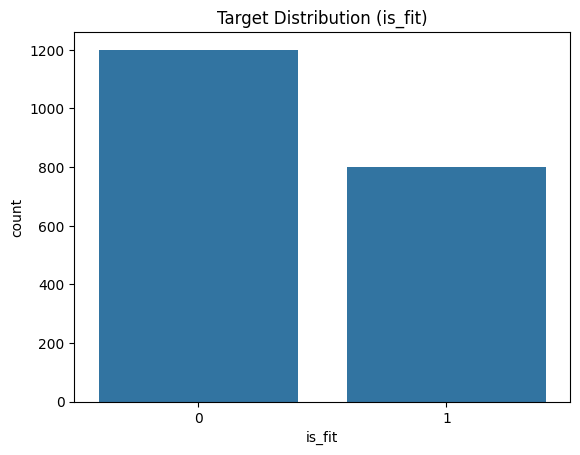

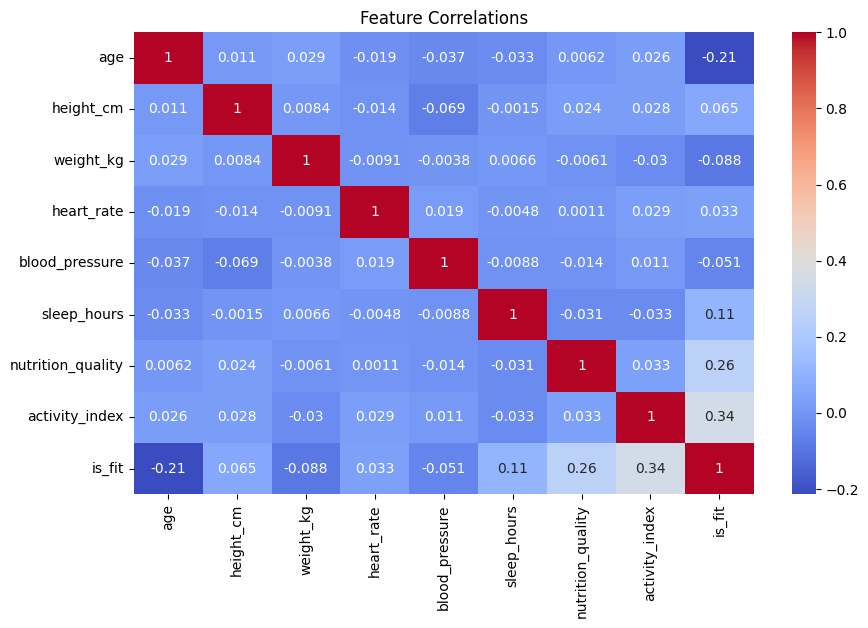

In [5]:
# ==============================
# 3. Initial EDA
# ==============================
print(df.info())
print(df.describe(include="all"))
print(df.isnull().sum())

# Target distribution
sns.countplot(x="is_fit", data=df)
plt.title("Target Distribution (is_fit)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

Missing values before imputation:
 160
Missing values after imputation:
 0


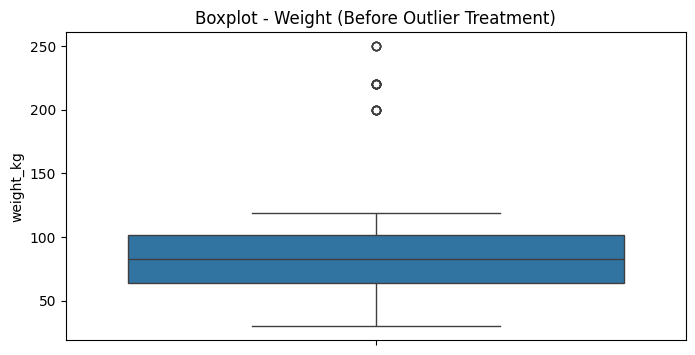

Shape after outlier removal: (1979, 11)


In [6]:
# ==============================
# 4. Data Cleaning & Preprocessing
# ==============================

# ---- Handle mixed data types in 'smokes' ----
df['smokes'] = df['smokes'].replace({'no': 0, 'yes': 1, 'No': 0, 'Yes': 1})
df['smokes'] = df['smokes'].astype(int)

# ---- Missing values in sleep_hours ----
print("Missing values before imputation:\n", df['sleep_hours'].isnull().sum())
df['sleep_hours'] = df['sleep_hours'].fillna(df['sleep_hours'].median())
print("Missing values after imputation:\n", df['sleep_hours'].isnull().sum())

# ---- Outlier detection in weight ----
plt.figure(figsize=(8,4))
sns.boxplot(df['weight_kg'])
plt.title("Boxplot - Weight (Before Outlier Treatment)")
plt.show()

# Z-score method
z_scores = np.abs(stats.zscore(df['weight_kg']))
df = df[(z_scores < 3)]  # remove extreme outliers
print("Shape after outlier removal:", df.shape)

# ---- Feature Engineering: BMI ----
df['BMI'] = df['weight_kg'] / ((df['height_cm']/100)**2)

# ---- Encoding categorical variables ----
df = pd.get_dummies(df, columns=['gender'], drop_first=True)  # M=1, F=0

In [7]:
# ==============================
# 5. Scaling for ML/NN
# ==============================
scaler = StandardScaler()
num_cols = ['age','height_cm','weight_kg','heart_rate','blood_pressure',
            'sleep_hours','nutrition_quality','activity_index','BMI']

df[num_cols] = scaler.fit_transform(df[num_cols])

print("Final dataset shape:", df.shape)
df.head()

Final dataset shape: (1979, 12)


,age,height_cm,weight_kg,heart_rate,blood_pressure,sleep_hours,nutrition_quality,activity_index,smokes,is_fit,BMI,gender_M
0,0.385156,-1.569736,-0.784747,-0.060950,-0.199909,-0.007839,-0.931391,0.854892,0,1,0.076136,False
1,1.111348,0.796014,0.591795,-0.803171,-0.350561,-0.007839,1.302434,0.168387,0,1,-0.001936,False
2,-0.173454,1.213499,0.958873,-0.752565,-0.240996,-0.007839,1.103484,-0.852571,0,0,0.053761,False
3,-0.955507,1.004756,0.041178,-0.853777,0.697157,-0.354132,0.398433,0.599653,0,1,-0.491364,True
4,0.608599,0.030624,0.775334,-1.030897,-0.282083,0.338454,1.714295,1.611809,1,1,0.561936,False


                age     height_cm     weight_kg    heart_rate  blood_pressure  \
count  1.979000e+03  1.979000e+03  1.979000e+03  1.979000e+03    1.979000e+03   
mean  -3.231372e-17 -6.238343e-16  2.980043e-16 -2.890282e-16    1.579782e-16   
std    1.000253e+00  1.000253e+00  1.000253e+00  1.000253e+00    1.000253e+00   
min   -1.737561e+00 -1.708898e+00 -2.390713e+00 -2.135795e+00   -2.048822e+00   
25%   -8.437855e-01 -8.739275e-01 -8.765166e-01 -6.935243e-01   -6.998002e-01   
50%   -5.871187e-03 -3.895686e-02 -4.706721e-03 -1.909338e-03    5.526013e-03   
75%    8.879041e-01  8.655946e-01  8.671031e-01  6.897056e-01    6.766131e-01   
max    1.669957e+00  1.700565e+00  1.693028e+00  4.071871e+00    3.511613e+00   

        sleep_hours  nutrition_quality  activity_index       smokes  \
count  1.979000e+03       1.979000e+03    1.979000e+03  1979.000000   
mean  -3.303180e-16       4.577777e-17    2.010631e-16     0.450227   
std    1.000253e+00       1.000253e+00    1.000253e+00   

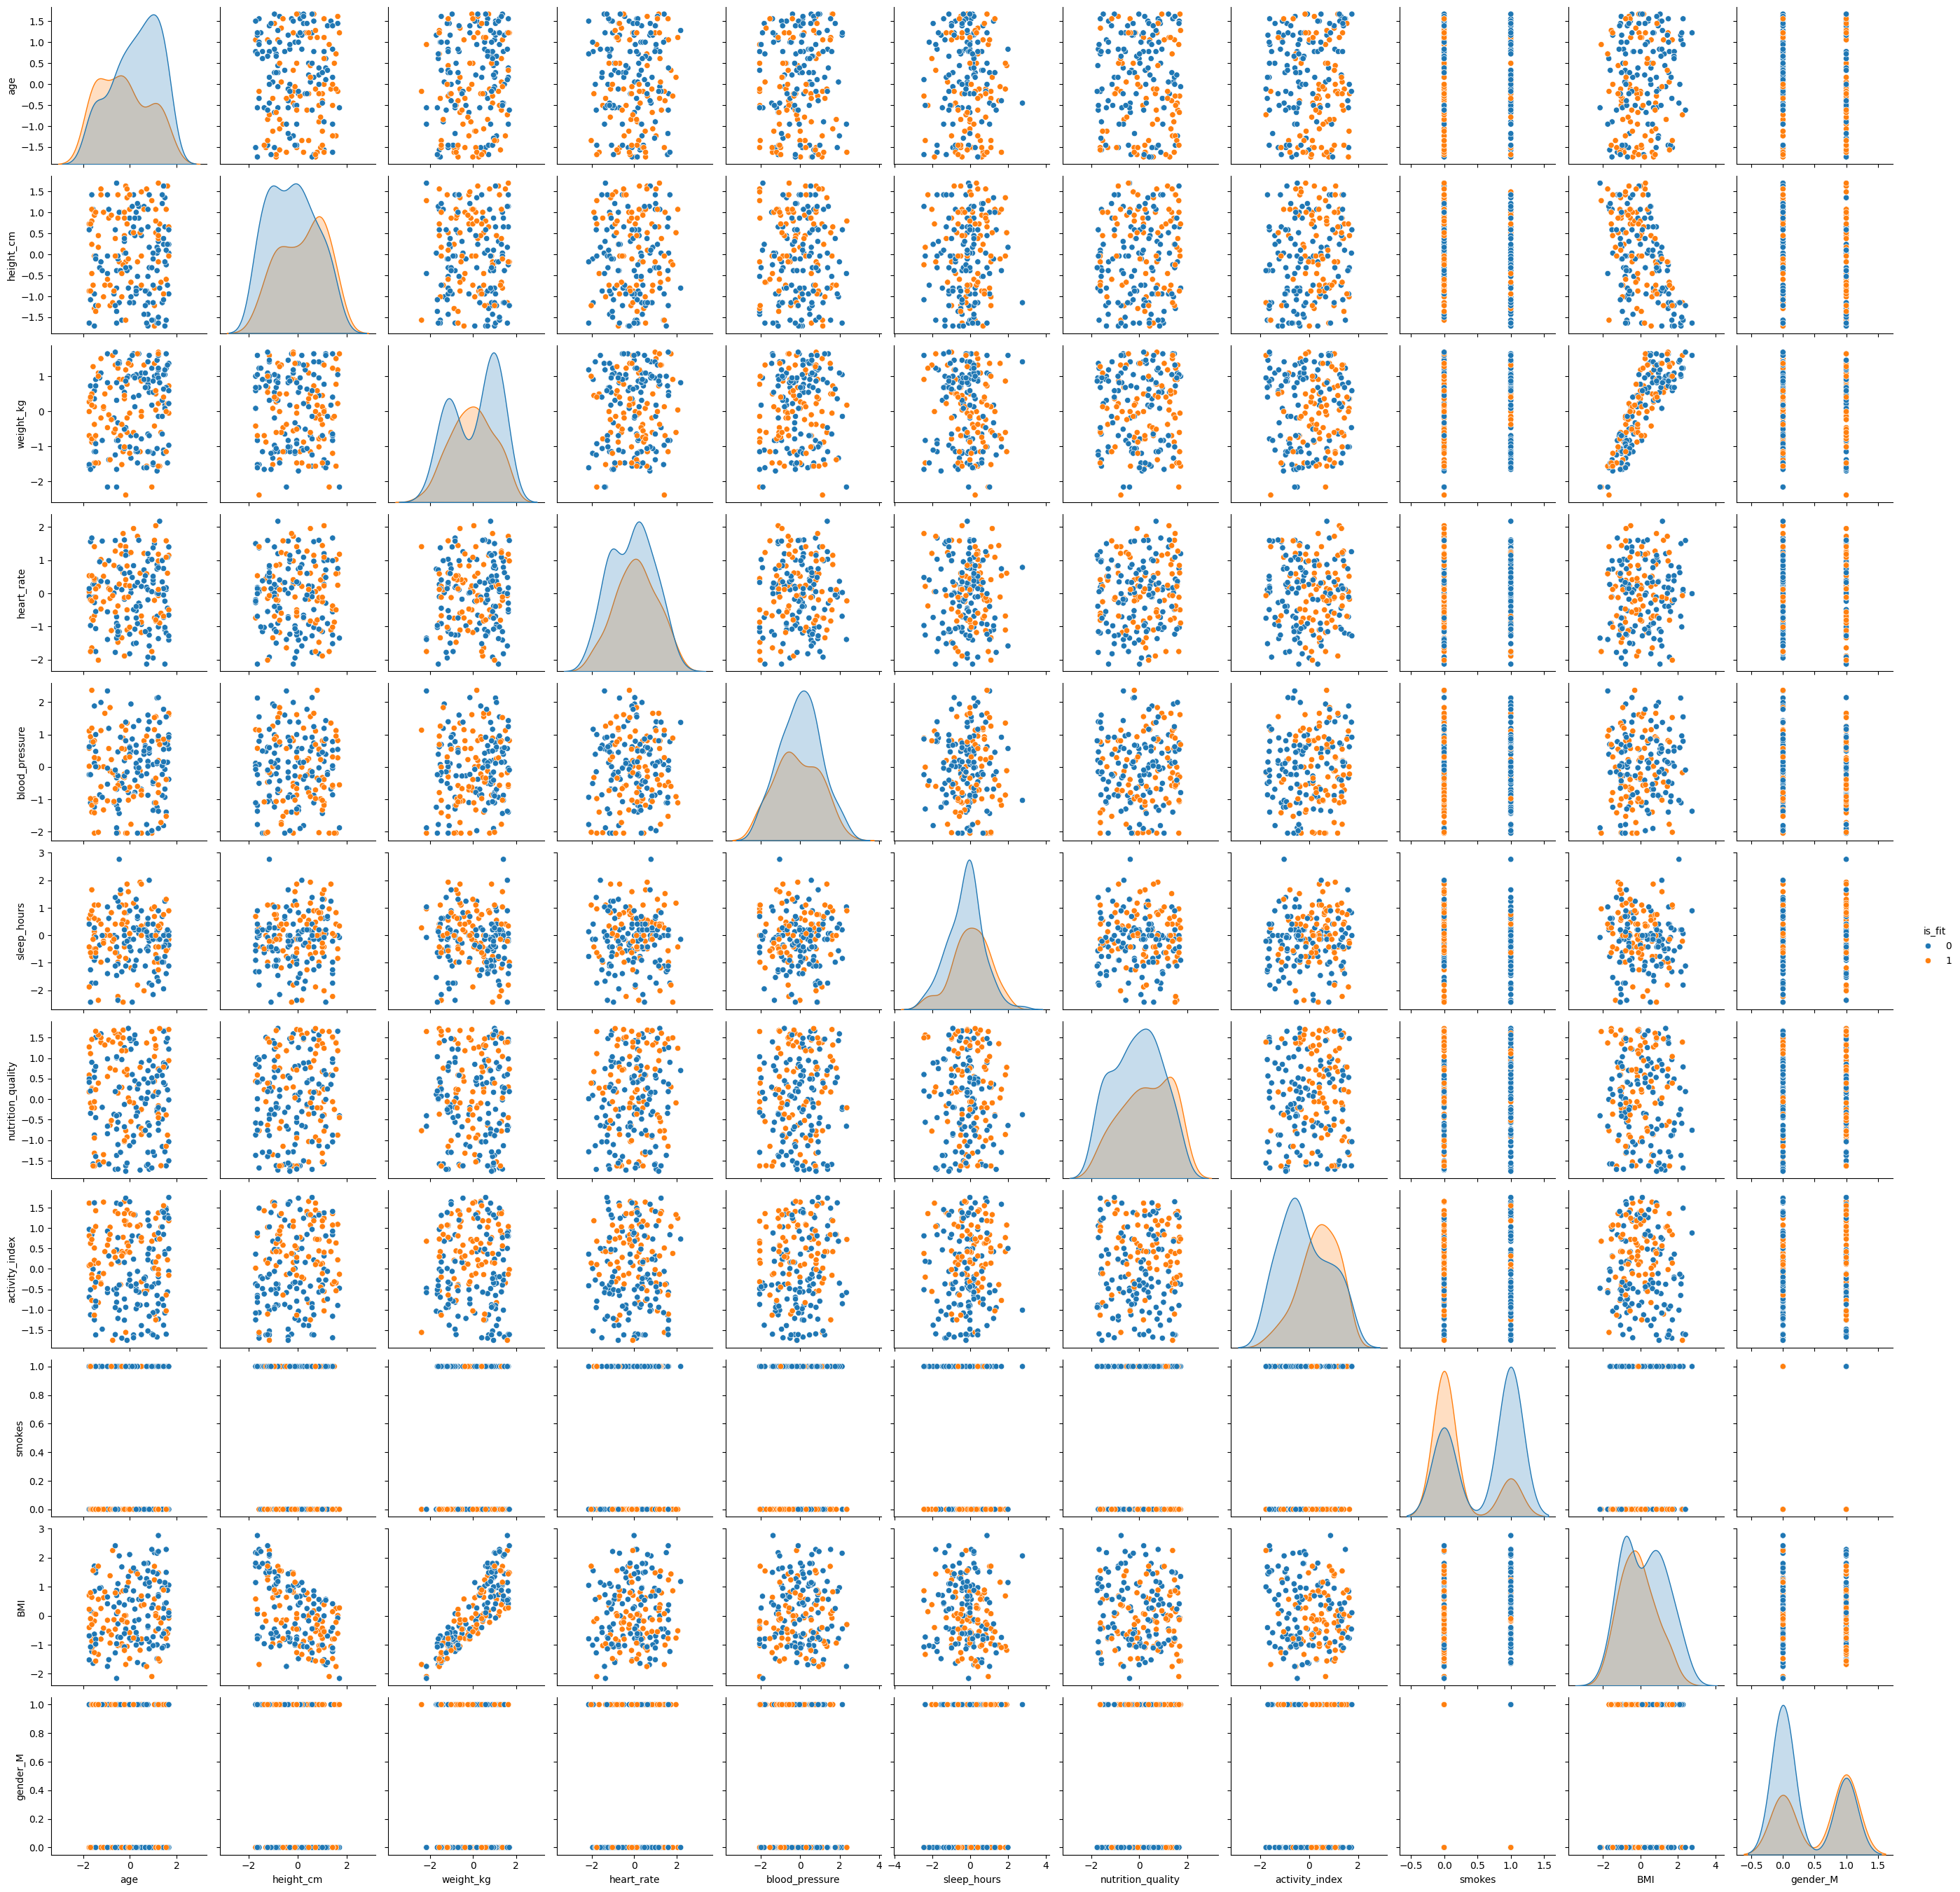

In [8]:
# ==============================
# 6. Final Checks
# ==============================
print(df.describe())
sns.pairplot(df.sample(200), hue="is_fit")
plt.show()

Class distribution (%):
 is_fit
0    59.878727
1    40.121273
Name: proportion, dtype: float64


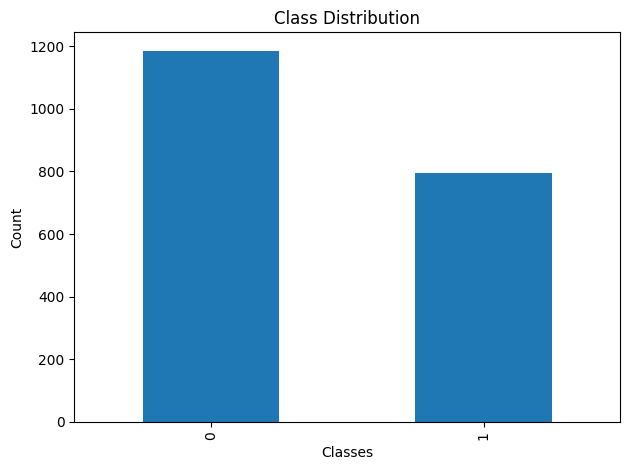

In [17]:
import matplotlib.pyplot as plt

def check_class_balance(df, target_col="target"):
    class_counts = df[target_col].value_counts(normalize=True) * 100
    print("Class distribution (%):\n", class_counts)

    # Plot
    ax = df[target_col].value_counts().plot(
        kind="bar", title="Class Distribution", legend=False
    )
    ax.set_xlabel("Classes")
    ax.set_ylabel("Count")
    
    plt.tight_layout()
    plt.show()  # <-- ensure it renders

check_class_balance(df, target_col="is_fit")





In [29]:
import os

from sklearn.model_selection import train_test_split

def split_train_test(df, target_col="target", test_size=0.2, random_state=42, stratify=True):
    """
    Split dataset into train and test sets.

    Parameters:
    - df: pandas DataFrame
    - target_col: str, target column
    - test_size: float, fraction for test data
    - random_state: int, random seed for reproducibility
    - stratify: bool, whether to stratify based on target_col
    
    Returns:
    - X_train, X_test, y_train, y_test
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]

    stratify_col = y if stratify else None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_col
    )

    print(f"✅ Data successfully split with test_size={test_size}")
    print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
    print("\nClass distribution in Train set (%):")
    print((y_train.value_counts(normalize=True) * 100).round(2))
    print("\nClass distribution in Test set (%):")
    print((y_test.value_counts(normalize=True) * 100).round(2))

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(df, target_col="is_fit", test_size=0.2)


import os

# Define project root explicitly (one level above notebooks)
PROJECT_ROOT = r"C:\Projects\fitness_prediction"
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")

def save_processed_data(X_train, X_test, y_train, y_test, processed_dir=PROCESSED_DIR):
    """
    Save train/test splits into the processed directory as CSV files.
    """
    os.makedirs(processed_dir, exist_ok=True)

    train_data = X_train.copy()
    train_data["target"] = y_train
    test_data = X_test.copy()
    test_data["target"] = y_test

    train_path = os.path.join(processed_dir, "train.csv")
    test_path = os.path.join(processed_dir, "test.csv")

    train_data.to_csv(train_path, index=False)
    test_data.to_csv(test_path, index=False)

    print(f"✅ Train data saved at: {train_path}")
    print(f"✅ Test data saved at: {test_path}")


✅ Data successfully split with test_size=0.2
Train set: (1583, 11), Test set: (396, 11)

Class distribution in Train set (%):
is_fit
0    59.89
1    40.11
Name: proportion, dtype: float64

Class distribution in Test set (%):
is_fit
0    59.85
1    40.15
Name: proportion, dtype: float64


In [30]:
# Step 2: Train-test split
X_train, X_test, y_train, y_test = split_train_test(df, target_col="is_fit", test_size=0.2)

# Step 3: Save processed train/test data (goes to C:\Projects\fitness_prediction\data\processed)
save_processed_data(X_train, X_test, y_train, y_test)


✅ Data successfully split with test_size=0.2
Train set: (1583, 11), Test set: (396, 11)

Class distribution in Train set (%):
is_fit
0    59.89
1    40.11
Name: proportion, dtype: float64

Class distribution in Test set (%):
is_fit
0    59.85
1    40.15
Name: proportion, dtype: float64
✅ Train data saved at: C:\Projects\fitness_prediction\data\processed\train.csv
✅ Test data saved at: C:\Projects\fitness_prediction\data\processed\test.csv
